In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Subscriber prediction during trial period
## Customer classifier

This notebook trains and evaluates a classifier predicting if a user will not cancel the subscription starting after the trial.
The model intends to capture the time influence on the likelihood of the subscription, based on the observation that there is more evidence and different implied behaviour for a user at the end than at the beggining of the trial.

#### Events modeled
- Every datapoint considered by the model, represents a day the user is active and combines both:
    - activity data daily aggregated and days since trial start
    - static user-based info added
- there are 86777 available datapoints
- It would be reasonable to define datapoints for every single record at the unaggregated activity dataset, understood as indivitual sessions. The ultimate decission should depend on how the model is used and under which trigger a prediction is requested.
- Given:
    - the strong influence on time component for the target variable
    - the fact that users drop during trial
    - the prediction of the user on censored data, not knowing if the user will keep active ahead on the trial
- it can resemble the settings for a survival analysis problem. However, this has been discarded in favor of regular classification modeling due to the fact that there is a fixed reckoning day when the trial finishes, unlike the classical churn model in which the user may cancel service at several moments.

#### The framework for modelling is LightGBM, because of:
- top accuracy
- extreme fast, enabling quick tries
- efficient use of memory, running on commodity machines
- minimal feature engineering requierments:
    - handles missing data
    - handles categorical features
    - handles unscaled fetures
- XGBoost is considered too, but:
    - does not handle categorical features naturally
    - is slower
    - is less efficient in resources

#### The evaluation metric is ROC AUC:
- target is balanced
- accounts for every probability threshold
- In oder to focus classification during early trial, metric is evaluated over test data splitted by day in trial. This way, any model improvemt may be oriented to optimize metric over this early data. This follows the general rule of validation data must reflect actual evaluation data.
- AUC grows with days in trial, reflecting the most uncertainty corresponds to the begining of the trial.
- Most sound metric is the corresponding to cross-validation
- train AUC is higher than cv AUC, because cv is measured over unseen data
- test AUC is slightly higher than cv, because test is measured using a model refit using every train fold.

#### Train-validation-test split:
- No user datapoint contains information from future datapoints.
- Even if rolling aggregated features were present, this statement would remain valid.
- Thus, random split is safe against target leakage.

#### Model inspection:
- Based on Shapley feature importance.
- Regular feature importance analysis based on info gain is displayed to show how a less robust analysis could mask even the obious nature of days in trial as a driving factor of the subscirption prediction.
- user_id: is the top predictor, probably leaking some target info, like sequential, mixed or legacy identification. Sequential seems probable, since the higher the id, the more probable of no-customer.
- days_since_trial: inspection confirms the intuition that the longer into the trial, the more likely to subscribe.
- age and price extremes correlate with high probability of subscription
- total_duration_game: inspection confirms the intuition that the higher, the more probable to subscribe
- iPar Air is the top device
- Philipines shows the lowest rate of subscribers.

#### Next steps:
- apply rolling aggregation features
- add record count
- use label encoding
- try different thresholds for high cardinality features
- provide frequency or mean label ordering
- extract day of month, day of week, hour
- create features for difference between dates
- grid search parameters

#### Code structure
- this notebook exposes high level implementation from the model src code
- current repository contains classes for main stages of modeling

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from dataset import Dataset
from feature_engineering import FeatureEngineering
from model import Model

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

In [3]:
ds = Dataset()

ds.make_dataset()

In [4]:
ds.df.head()

,user_id,onboarding_home_at,os_name,os_version,country,timezone,locale,device_type,device_model,source,...,total_feature_16,total_feature_17,mean_feature_10,mean_feature_11,mean_feature_12,mean_feature_13,mean_feature_18,mean_feature_19,mean_feature_20,mean_feature_21
0,23581630,2020-12-20T22:15:39Z,iOS,14.2,us,America/Los_Angeles,en,Apple,iPhone 6s Plus,launcher,...,547.600,110.033,68.127308,21.430917,10.140741,18.338833,0.364744,0.0,0.242074,0.399333
1,23581630,2020-12-20T22:15:39Z,iOS,14.2,us,America/Los_Angeles,en,Apple,iPhone 6s Plus,launcher,...,158.029,0.000,179.312571,82.030300,31.605800,0.000000,1.796143,0.0,0.780000,0.000000
2,23581630,2020-12-20T22:15:39Z,iOS,14.2,us,America/Los_Angeles,en,Apple,iPhone 6s Plus,launcher,...,384.632,0.000,108.590786,51.121111,17.483273,0.000000,0.437607,0.0,0.373818,0.000000
3,23581630,2020-12-20T22:15:39Z,iOS,14.2,us,America/Los_Angeles,en,Apple,iPhone 6s Plus,launcher,...,189.662,192.496,145.062308,57.963571,27.094571,64.165333,1.322538,0.0,0.730429,1.311000
4,23581630,2020-12-20T22:15:39Z,iOS,14.2,us,America/Los_Angeles,en,Apple,iPhone 6s Plus,launcher,...,59.225,0.000,112.414714,42.678000,29.612500,0.000000,0.942929,0.0,1.042500,0.000000


In [5]:
fe = FeatureEngineering(ds.df)
fe.featurize()
print(fe.df.shape)
fe.df.head()

(86777, 28)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,user_id,os_name,os_version,country,locale,device_type,device_model,source,level,age,...,total_feature_17,mean_feature_10,mean_feature_11,mean_feature_12,mean_feature_13,mean_feature_18,mean_feature_19,mean_feature_20,mean_feature_21,customer
0,23581630,iOS,14.2,us,en,Apple,iPhone 6s Plus,launcher,beginner,3.0,...,110.033,68.127308,21.430917,10.140741,18.338833,0.364744,0.0,0.242074,0.399333,1
1,23581630,iOS,14.2,us,en,Apple,iPhone 6s Plus,launcher,beginner,3.0,...,0.000,179.312571,82.030300,31.605800,0.000000,1.796143,0.0,0.780000,0.000000,1
2,23581630,iOS,14.2,us,en,Apple,iPhone 6s Plus,launcher,beginner,3.0,...,0.000,108.590786,51.121111,17.483273,0.000000,0.437607,0.0,0.373818,0.000000,1
3,23581630,iOS,14.2,us,en,Apple,iPhone 6s Plus,launcher,beginner,3.0,...,192.496,145.062308,57.963571,27.094571,64.165333,1.322538,0.0,0.730429,1.311000,1
4,23581630,iOS,14.2,us,en,Apple,iPhone 6s Plus,launcher,beginner,3.0,...,0.000,112.414714,42.678000,29.612500,0.000000,0.942929,0.0,1.042500,0.000000,1


In [6]:
fe.df["price"].describe()

count    86777.000000
mean       157.914012
std       1589.899670
min          6.358587
25%         14.990000
50%         15.987669
75%         18.701540
max      95900.000000
Name: price, dtype: float64

In [7]:
model = Model(df=fe.df)

model.split_train_test()

len(model.train), len(model.test), len(model.train.columns)

(60743, 26034, 28)

In [8]:
sumary = model.train_and_evaluate()

[LightGBM] [Info] Number of positive: 21183, number of negative: 24374
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3299
[LightGBM] [Info] Number of data points in the train set: 45557, number of used features: 27
[LightGBM] [Info] Number of positive: 21230, number of negative: 24327
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3299
[LightGBM] [Info] Number of data points in the train set: 45557, number of used features: 27
[LightGBM] [Info] Number of positive: 21261, number of negative: 24296
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead o

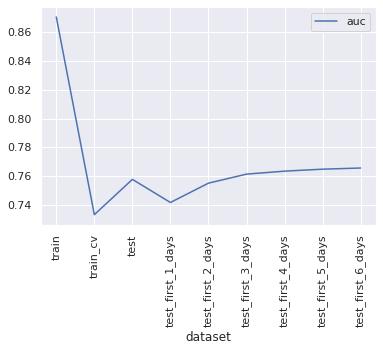

In [9]:
model.plot_summary()

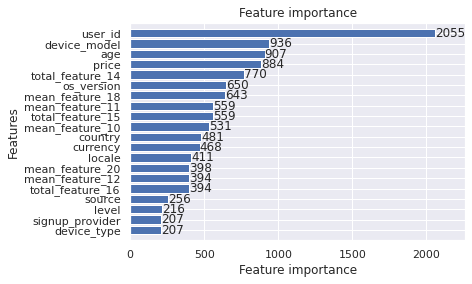

In [10]:
model.inspect_importance_info_gain()

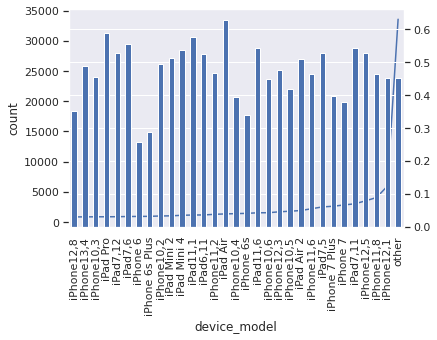

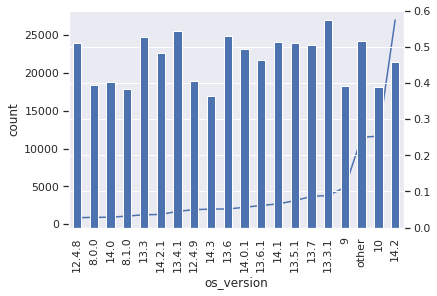

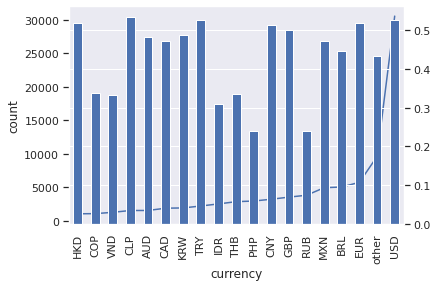

In [11]:
for feat in ["device_model", "os_version", "currency"]:
    model.inspect_feat_cat(feat)

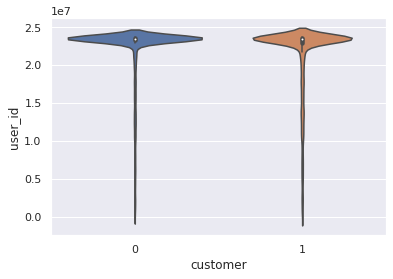

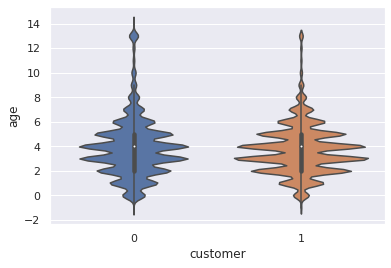

In [12]:
for feat in ["user_id", "age"]:
    model.inspect_feat_num(feat)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


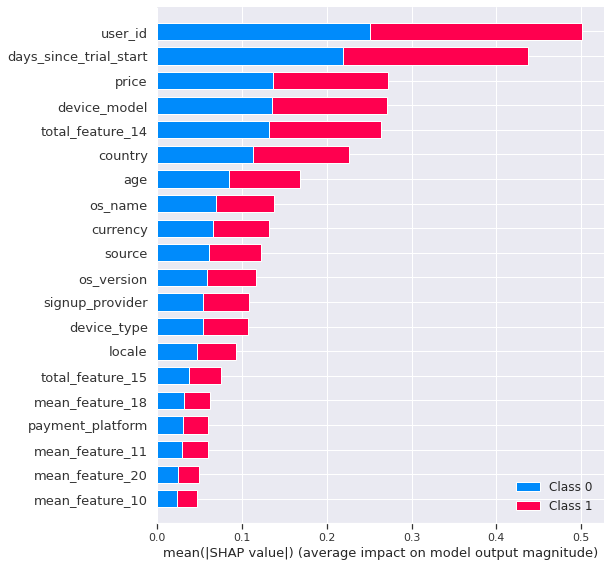

In [13]:
model.inspect_feat_importance()

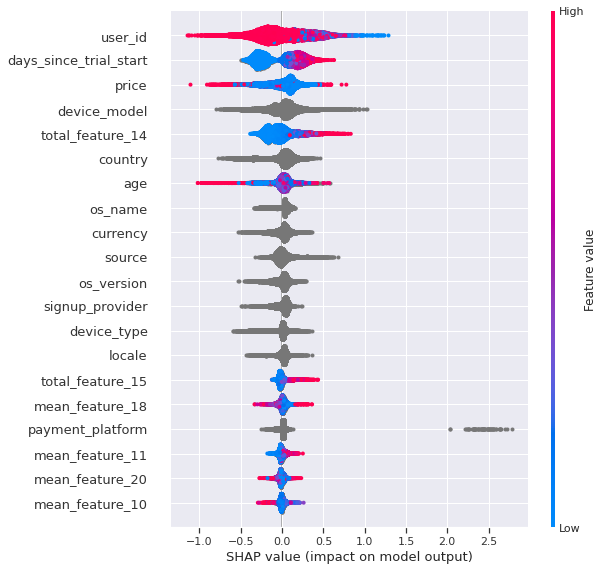

In [14]:
model.inspect_feat_impact()